Boxing Tool (Figure 2)

- This code can be used to select and filter 2fce, 3fce, and 4fce events
- User can select and box one file at a time

In [8]:
'2fce'

%matplotlib ipympl
import glob
#import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector, TextBox
import scipy 
from scipy import stats

In [9]:
#User Select file_number:

filepath = '/Volumes/PassportDrive/interferometer-data/data-sent-by-jim/DataCopy/new_data/3-25-234-event/'
filepath_len = len(filepath)

file_number = 0

files = glob.glob('{}*-2-red'.format(filepath))     
file = files[file_number]
filename = file[ filepath_len : filepath_len + 18 ]
print('Filename Selected: ',filename)

Filename Selected:  20230325-0819-0832


In [10]:
'Data Framing'

df = pd.read_csv(file,header=None,delim_whitespace=True)
print(df)
freq = df.loc[df[1].le(2900.) & df[1].ge(2500.)]
print(freq)
t = freq.loc[:,0].to_numpy()
f = freq.loc[:,1].to_numpy()
p = freq.loc[:,2].to_numpy()
event_xmin,event_xmax,event_ymin,event_ymax = [],[],[],[]
line_minimum,line_maximum = [],[]

                0           1    2   3    4
0        0.000000  2945.86182  -98  60  146
1        0.000000  2946.16699  -96  54  166
2        0.000000  2947.38770  -99  61  140
3        0.000000  2948.91357  -96  60  153
4        0.000000  2963.56201 -100 -94 -999
...           ...         ...  ...  ..  ...
101044  59.978542  2768.85986  -67 -94 -999
101045  59.978542  2769.16504  -88 -94 -999
101046  59.978542  2770.69092  -93 -94 -999
101047  59.978542  2770.99609  -99 -94 -999
101048  59.978542  2771.30127  -97 -94 -999

[101049 rows x 5 columns]
                0           1   2   3    4
29       0.052429  2682.80029 -98 -94 -999
30       0.052429  2684.32617 -78  62  167
31       0.052429  2684.93652 -91 -94 -999
32       0.052429  2685.54712 -81  42  139
33       0.052429  2686.15723 -93  65   91
...           ...         ...  ..  ..  ...
101044  59.978542  2768.85986 -67 -94 -999
101045  59.978542  2769.16504 -88 -94 -999
101046  59.978542  2770.69092 -93 -94 -999
101047  59.9785

In [89]:
'Spectrogram'

plt.figure(figsize=(20,7))
cm = plt.cm.get_cmap('jet')
image = plt.scatter(t,f, c=p,s=0.1,cmap=cm,vmin=-150,vmax=150) 
plt.colorbar(image)
plt.ticklabel_format(useOffset=False)
plt.title('Spectrogram: {}'.format(filename),fontsize=20)
#plt.savefig('{}{}_spectrogram_2fce.png'.format(filepath,filename))
#plt.show()

In [ ]:
plt.close()

In [11]:
def binning(t,f,p):
    
    p_exp = np.exp(p)
    x_range = np.linspace(np.min(t),np.max(t),num=300)
    y_range = np.linspace(np.min(f),np.max(f),num=300)
    xbins, ybins = len(x_range), len(y_range)
    Z,xedge,yedge,binnumber = stats.binned_statistic_2d(t, f, p_exp, 'mean',bins = [xbins, ybins])
    xedge = xedge[:-1]
    yedge = yedge[:-1]
    Z = np.ma.masked_invalid(Z)
    X, Y = np.meshgrid(xedge, yedge, indexing = 'ij')
    return X,Y,Z

In [12]:
def onselect(eclick, erelease):
    
    x1, x2 = min(eclick.xdata, erelease.xdata), max(eclick.xdata, erelease.xdata)
    y1, y2 = min(eclick.ydata, erelease.ydata), max(eclick.ydata, erelease.ydata)
    x = (X > x1) & (X < x2) 
    y = (Y > y1) & (Y < y2)
    xmask = X[x]
    ymask = Y[y]
    event_xmin.append(np.min(xmask))
    event_xmax.append(np.max(xmask))
    event_ymin.append(np.min(ymask))
    event_ymax.append(np.max(ymask))  

In [13]:
def real_data_from_rectangle(data):
    
    rect_t,rect_f,rect_z,rect_e,rect_a = [],[],[],[],[]
    for i in range(len(event_xmin)):
        rect_time_filt = data.loc[data[0].le(event_xmax[i]) & data[0].ge(event_xmin[i])]
        rect_time_freq_filt = rect_time_filt.loc[rect_time_filt[1].le(event_ymax[i]) & rect_time_filt[1].ge(event_ymin[i])]
        rect_t = np.append(rect_t, rect_time_freq_filt.loc[:,0].to_numpy())
        rect_f = np.append(rect_f, rect_time_freq_filt.loc[:,1].to_numpy())
        rect_z = np.append(rect_z, rect_time_freq_filt.loc[:,2].to_numpy())
        rect_e = np.append(rect_e, rect_time_freq_filt.loc[:,3].to_numpy())
        rect_a = np.append(rect_a, rect_time_freq_filt.loc[:,4].to_numpy())
    return rect_t,rect_f,rect_z,rect_e,rect_a


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: The 'rectprops' parameter of __init__() has been renamed 'props' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  app.launch_new_instance()


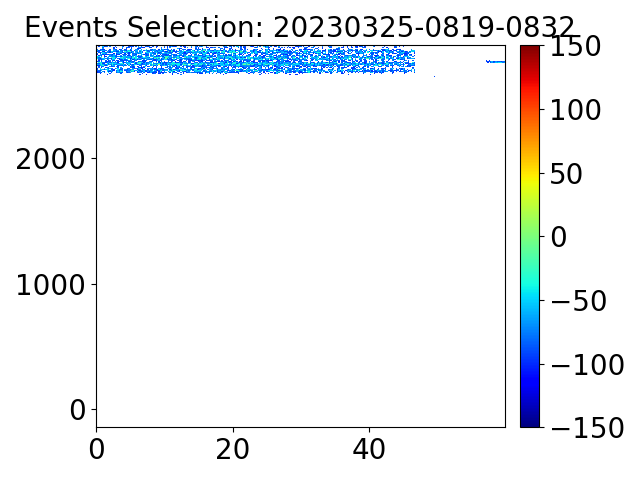

In [14]:
'Event Selection'

X,Y,Z = binning(t,f,p)

fig = plt.figure()
cm = plt.cm.get_cmap('jet')
ax1=plt.subplot(111)
ax1.set_title('Events Selection: {}'.format(filename),fontsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)
Z_log = np.log(Z)
plot1 = ax1.pcolormesh(X,Y,Z_log,cmap=cm,vmin=-150,vmax=150)
cbar = plt.colorbar(plot1,pad=0.03)
cbar.ax.tick_params(labelsize=20)
rect_selector = RectangleSelector(ax1, onselect, interactive=True,
                                 rectprops=dict(facecolor='blue', edgecolor='black', alpha=0.05, fill=True))
plt.tight_layout()
plt.show()
#plt.savefig('{}{}_event_selection_2fce.png'.format(filepath,filename))

In [15]:
plt.close()
rect_t,rect_f,rect_z,rect_e,rect_a = real_data_from_rectangle(freq)
rect_data = pd.DataFrame({'0': rect_t[:],'1': rect_f[:],'2': rect_z[:],'3': rect_e[:],'4': rect_a[:]})

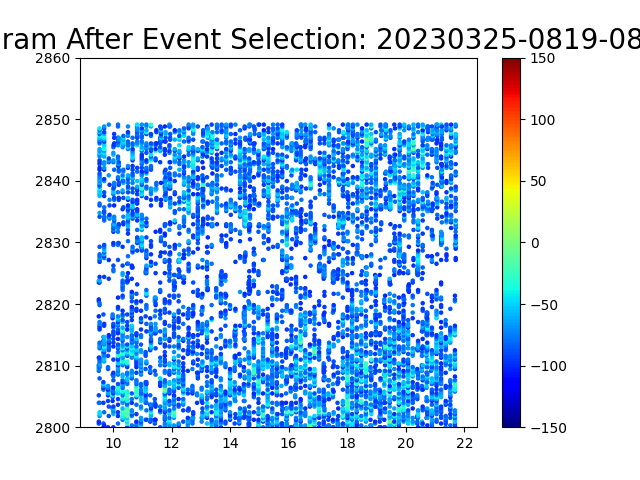

In [17]:
'Spectrogram After Event Selection'

x_test = rect_data['0'].to_numpy()
y_test = rect_data['1'].to_numpy()
z_test = rect_data['2'].to_numpy()

plt.figure()
plt.ylim(2800,2860)
cm = plt.cm.get_cmap('jet')
image = plt.scatter(x_test,y_test, c=z_test,s=5,cmap=cm,vmin=-150,vmax=150)
plt.colorbar(image)
plt.title('Spectrogram After Event Selection: {}'.format(filename),fontsize=20)
plt.show()
#plt.savefig('{}{}_spectrogram_after_event_selection_2fce.png'.format(filepath,filename))

In [ ]:
plt.close()

In [96]:
def onselect(eclick, erelease):
    
    x1, x2 = min(eclick.xdata, erelease.xdata), max(eclick.xdata, erelease.xdata)
    y1, y2 = min(eclick.ydata, erelease.ydata), max(eclick.ydata, erelease.ydata)
    x = (X > x1) & (X < x2) 
    y = (Y > y1) & (Y < y2)
    int_mask = Y[y]
    line_minimum.append(np.min(int_mask))
    line_maximum.append(np.max(int_mask))

In [97]:
'Interference Selection'

X,Y,Z = binning(t,f,p)

fig = plt.figure(figsize = (20,7))
cm = plt.cm.get_cmap('jet')
ax1=plt.subplot(111)
ax1.set_title('Interference Lines Selection',fontsize=20)
Z_log = np.log(Z)
plot1 = ax1.pcolormesh(X,Y,Z_log,cmap=cm,vmin=-150,vmax=150)
plt.colorbar(plot1)
rect_selector = RectangleSelector(ax1, onselect, interactive=True,
                                 rectprops=dict(facecolor='blue', edgecolor='black', alpha=0.05, fill=True))
plt.show()

In [98]:
'Removing Interference Lines by Filtering Frequency Column'

plt.close()

filtered = rect_data.copy()
for i in range(len(line_minimum)):
    filtered = filtered.loc[rect_data['1'].le(line_minimum[i]) | rect_data['1'].ge(line_maximum[i])]

In [99]:
'Spectrogram After Event Selection and Removal of Interference Lines'

time_array = filtered['0'].to_numpy()
freq_array = filtered['1'].to_numpy()
pow_array = filtered['2'].to_numpy()

plt.figure(figsize=(20,7))
plt.tick_params(axis='y', labelsize=20)
cm = plt.cm.get_cmap('jet')
image = plt.scatter(time_array,freq_array, c=pow_array,s=5.0,cmap=cm,vmin=-150,vmax=150)
cbar = plt.colorbar(image, pad=0.3)
cbar.ax.tick_params(labelsize=20)
plt.title('After Interference Removal: {}'.format(filename),fontsize=20)
plt.tight_layout()
plt.show()
#plt.savefig('{}{}_spectrogram_after_interference_removal_2fce.png'.format(filepath,filename))

In [100]:
'Filtering'

plt.close()

pow_filter = filtered.loc[filtered['2'].ge(-400.)]
el_filter = pow_filter.loc[pow_filter['3'].le(90.) & pow_filter['3'].ge(0.)]
az_filter = el_filter.loc[el_filter['4'].le(360.) & el_filter['4'].ge(-180.)]

In [101]:
'Polar Plot'

elevation = az_filter.loc[:,'3'].to_numpy()
az = az_filter.loc[:,'4'].to_numpy()
for i,angle in enumerate(az):
    if angle < 0 :
        az[i] = angle + 360
azimuth = az*np.pi/180

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='polar')
ax.set_rlim(bottom=90, top=0)
ax.xaxis.grid(True,color='dimgray')
ax.yaxis.grid(True,color='dimgray')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_yticklabels(['0','10','20','30','40','50','60','70','80','90'],fontsize=15,color='silver')
ax.set_rlabel_position(20.0)
ax.set_xticklabels(['N', '', 'E', '', 'S', '', 'W', ''],fontsize=20,color='k')
c = ax.scatter(azimuth,elevation,s=4,color='r',alpha=0.15)
plt.show()
#plt.savefig('{}{}_polar_plot_2fce.png'.format(filepath,filename))

In [ ]:
plt.close()

'Writing Filtered Data to Files'

naming = filename + '-filtered-data'
az_filter.to_csv('{}{}.csv'.format(filepath,naming),
                                                                index = False,header = False,sep = ' ')

'Opening Written Files to Check Formatting'

new_file = '{}{}.csv'.format(filepath,naming)
check = pd.read_csv(new_file,header=None,delim_whitespace=True)
print(check)

In [53]:
'3fce'

%matplotlib  #pop-out window
import glob
#import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector, TextBox
import scipy 
from scipy import stats

Using matplotlib backend: MacOSX


In [54]:
#User Select file_number:

filepath = '/Volumes/PassportDrive/interferometer-data/data-sent-by-jim/DataCopy/new_data/3-25-234-event/'
filepath_len = len(filepath)

file_number = 0

files = glob.glob('{}*-3-red'.format(filepath))
file = files[file_number]
filename = file[ filepath_len : filepath_len + 18 ]
print('Filename Selected: ',filename)

20230325-0819-0832


In [ ]:
'Data Framing'

df = pd.read_csv(file,header=None,delim_whitespace=True)
ele = df.loc[df[3].ge(0.)]
freq = ele.loc[ele[1].le(4400.) & ele[1].ge(3700.)]
t = freq.loc[:,0].to_numpy()
f = freq.loc[:,1].to_numpy()
p = freq.loc[:,2].to_numpy()
event_xmin,event_xmax,event_ymin,event_ymax = [],[],[],[]
line_minimum,line_maximum = [],[]

In [55]:
'Spectrogram'

plt.figure(figsize=(20,7))
cm = plt.cm.get_cmap('jet')
image = plt.scatter(t,f, c=p,s=0.1,cmap=cm,vmin=-120,vmax=-20)
plt.colorbar(image)
plt.ticklabel_format(useOffset=False)
plt.title('Real Data: {}'.format(filename),fontsize=20)
plt.show()
#plt.savefig('{}{}_spectrogram_3fce.png'.format(filepath,filename))

In [ ]:
plt.close()

In [56]:
def binning(t,f,p):
    
    p_exp = np.exp(p)
    x_range = np.linspace(np.min(t),np.max(t),num=300)
    y_range = np.linspace(np.min(f),np.max(f),num=300)
    xbins, ybins = len(x_range), len(y_range)
    Z,xedge,yedge,binnumber = stats.binned_statistic_2d(t, f, p_exp, 'mean',bins = [xbins, ybins])
    xedge = xedge[:-1]
    yedge = yedge[:-1]
    Z = np.ma.masked_invalid(Z)
    X, Y = np.meshgrid(xedge, yedge, indexing = 'ij')
    return X,Y,Z

In [57]:
def onselect(eclick, erelease):
    
    x1, x2 = min(eclick.xdata, erelease.xdata), max(eclick.xdata, erelease.xdata)
    y1, y2 = min(eclick.ydata, erelease.ydata), max(eclick.ydata, erelease.ydata)
    x = (X > x1) & (X < x2) 
    y = (Y > y1) & (Y < y2)
    xmask = X[x]
    ymask = Y[y]
    event_xmin.append(np.min(xmask))
    event_xmax.append(np.max(xmask))
    event_ymin.append(np.min(ymask))
    event_ymax.append(np.max(ymask))   

In [58]:
def real_data_from_rectangle(data):
    
    rect_t,rect_f,rect_z,rect_e,rect_a = [],[],[],[],[]
    for i in range(len(event_xmin)):
        rect_time_filt = data.loc[data[0].le(event_xmax[i]) & data[0].ge(event_xmin[i])]
        rect_time_freq_filt = rect_time_filt.loc[rect_time_filt[1].le(event_ymax[i]) & rect_time_filt[1].ge(event_ymin[i])]
        rect_t = np.append(rect_t, rect_time_freq_filt.loc[:,0].to_numpy())
        rect_f = np.append(rect_f, rect_time_freq_filt.loc[:,1].to_numpy())
        rect_z = np.append(rect_z, rect_time_freq_filt.loc[:,2].to_numpy())
        rect_e = np.append(rect_e, rect_time_freq_filt.loc[:,3].to_numpy())
        rect_a = np.append(rect_a, rect_time_freq_filt.loc[:,4].to_numpy())
    return rect_t,rect_f,rect_z,rect_e,rect_a


In [59]:
'Event Selection'

X,Y,Z = binning(t,f,p)
  
fig = plt.figure(figsize = (20,7))
cm = plt.cm.get_cmap('jet')
ax1=plt.subplot(111)
ax1.set_title('Events Selection: {}'.format(filename),fontsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)
Z_log = np.log(Z)
plot1 = ax1.pcolormesh(X,Y,Z_log,cmap=cm,vmin=-150,vmax=100)
cbar = plt.colorbar(plot1,pad=0.03)
cbar.ax.tick_params(labelsize=20)
rect_selector = RectangleSelector(ax1, onselect, interactive=True,
                                 rectprops=dict(facecolor='blue', edgecolor='black', alpha=0.05, fill=True))
plt.tight_layout()
plt.show()
#plt.savefig('{}{}_event_selection_3fce.png'.format(filepath,filename))

In [60]:
plt.close()

rect_t,rect_f,rect_z,rect_e,rect_a = real_data_from_rectangle(freq)
rect_data = pd.DataFrame({'0': rect_t[:],'1': rect_f[:],'2': rect_z[:],'3': rect_e[:],'4': rect_a[:]})

In [61]:
'Spectrogram After Event Selection'

x_test = rect_data['0'].to_numpy()
y_test = rect_data['1'].to_numpy()
z_test = rect_data['2'].to_numpy()

plt.figure(figsize=(20,7))
cm = plt.cm.get_cmap('jet')
image = plt.scatter(x_test,y_test, c=z_test,s=5,cmap=cm,vmin=-150,vmax=100)
plt.colorbar(image)
plt.ticklabel_format(useOffset=False)
plt.title('Spectrogram After Event Selection: {}'.format(filename),fontsize=20)
plt.show()
#plt.savefig('{}{}_spectrogram_after_event_selection_3fce.png'.format(filepath,filename))

In [ ]:
plt.close()

In [62]:
def onselect(eclick, erelease):
    
    x1, x2 = min(eclick.xdata, erelease.xdata), max(eclick.xdata, erelease.xdata)
    y1, y2 = min(eclick.ydata, erelease.ydata), max(eclick.ydata, erelease.ydata)
    x = (X > x1) & (X < x2) 
    y = (Y > y1) & (Y < y2)
    int_mask = Y[y]
    line_minimum.append(np.min(int_mask))
    line_maximum.append(np.max(int_mask))

In [63]:
'Interference Line Selection'

X,Y,Z = binning(t,f,p)

fig = plt.figure(figsize = (20,7))
cm = plt.cm.get_cmap('jet')
ax1=plt.subplot(111)
ax1.set_title('Interference Lines Selection',fontsize=20)
Z_log = np.log(Z)
plot1 = ax1.pcolormesh(X,Y,Z_log,cmap=cm,vmin=-150,vmax=100)
plt.colorbar(plot1)
rect_selector = RectangleSelector(ax1, onselect, interactive=True,
                                 rectprops=dict(facecolor='blue', edgecolor='black', alpha=0.05, fill=True))
plt.show()

In [64]:
'Removing Interference Lines by Filtering Frequency Column'

plt.close()

filtered = rect_data.copy()
for i in range(len(line_minimum)):
    filtered = filtered.loc[rect_data['1'].le(line_minimum[i]) | rect_data['1'].ge(line_maximum[i])]

In [65]:
'Spectrogram After Event Selection and Removal of Interference Lines'

time_array = filtered['0'].to_numpy()
freq_array = filtered['1'].to_numpy()
pow_array = filtered['2'].to_numpy()

plt.figure(figsize=(16,4))
#plt.ylim(2800,2860)
#plt.tick_params(axis='y', labelsize=20)
#plt.xticks([])
cm = plt.cm.get_cmap('jet')
image = plt.scatter(time_array,freq_array, c=pow_array,s=5,cmap=cm,vmin=-120,vmax=-20)
plt.colorbar(image)
plt.ticklabel_format(useOffset=False)
#cbar = plt.colorbar(image, pad=0.3)
#cbar.ax.tick_params(labelsize=20)
plt.title('Interference Lines Removal Check: {}'.format(filename),fontsize=20)
plt.tight_layout()
plt.show()
#plt.savefig('{}{}_spectrogram_after_interference_removal_3fce.png'.format(filepath,filename))

In [66]:
'Filtering'

plt.close()

pow_filter = filtered.loc[filtered['2'].ge(-150.)]
el_filter = pow_filter.loc[pow_filter['3'].le(90.) & pow_filter['3'].ge(0.)]
az_filter = el_filter.loc[el_filter['4'].le(360.) & el_filter['4'].ge(-180.)]

In [67]:
'Polar Plot'

elevation = az_filter.loc[:,'3'].to_numpy()
az = az_filter.loc[:,'4'].to_numpy()
for i,angle in enumerate(az):
    if angle < 0 :
        az[i] = angle + 360
azimuth = az*np.pi/180

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='polar')
ax.set_rlim(bottom=90, top=0)
ax.xaxis.grid(True,color='dimgray')
ax.yaxis.grid(True,color='dimgray')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_yticklabels(['0','10','20','30','40','50','60','70','80','90'],fontsize=15,color='silver')
ax.set_rlabel_position(20.0)
ax.set_xticklabels(['N', '', 'E', '', 'S', '', 'W', ''],fontsize=20,color='k')
c = ax.scatter(azimuth,elevation,s=4,color='r',alpha=0.15)
plt.show()
#plt.savefig('{}{}_polar_plot_3fce.png'.format(filepath,filename))

In [ ]:
plt.close()

'Writing Data to Files'

naming = filename + '-filtered-data'
az_filter.to_csv('{}{}.csv'.format(filepath,naming),
                                                                index = False,header = False,sep = ' ')

'Opening Written Files to Check Formatting'

new_file = '{}{}.csv'.format(filepath,naming)
check = pd.read_csv(new_file,header=None,delim_whitespace=True)
#print(check)

In [223]:
'4fce'

%matplotlib  #pop-out window
import glob
#import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import RectangleSelector, TextBox
import scipy 
from scipy import stats

Using matplotlib backend: MacOSX


In [224]:
#User select file_number:

filepath = '/Volumes/PassportDrive/interferometer-data/data-sent-by-jim/DataCopy/new_data/3-25-234-event/'
filepath_len = len(filepath)

file_number = 0

files = glob.glob('{}*4.5'.format(filepath))
file = files[file_number]
filename = file[ filepath_len : filepath_len + 18 ]
print('Filename Selected: ',filename)

20230325-0819-0832


In [ ]:
'Data Framing'

df = pd.read_csv(file,header=None,delim_whitespace=True)
ele = df.loc[df[3].ge(0.)]
freq = ele.loc[ele[1].le(4800.) & ele[1].ge(4400.)]
t = freq.loc[:,0].to_numpy()
f = freq.loc[:,1].to_numpy()
p = freq.loc[:,2].to_numpy()
event_xmin,event_xmax,event_ymin,event_ymax = [],[],[],[]
line_minimum,line_maximum = [],[]

In [225]:
'Spectrogram'

plt.figure(figsize=(20,7))
cm = plt.cm.get_cmap('jet')
image = plt.scatter(t,f, c=p,s=0.1,cmap=cm,vmin=-120,vmax=-20)
plt.colorbar(image)
plt.ticklabel_format(useOffset=False)
plt.title('Real Data: {}'.format(filename),fontsize=20)
plt.show()
#plt.savefig('{}{}_spectrogram_4fce.png'.format(filepath,filename))

In [ ]:
plt.close()

In [226]:
def binning(t,f,p):
    
    p_exp = np.exp(p)
    x_range = np.linspace(np.min(t),np.max(t),num=300)
    y_range = np.linspace(np.min(f),np.max(f),num=300)
    xbins, ybins = len(x_range), len(y_range)
    Z,xedge,yedge,binnumber = stats.binned_statistic_2d(t, f, p_exp, 'mean',bins = [xbins, ybins])
    xedge = xedge[:-1]
    yedge = yedge[:-1]
    Z = np.ma.masked_invalid(Z)
    X, Y = np.meshgrid(xedge, yedge, indexing = 'ij')
    return X,Y,Z

In [227]:
def onselect(eclick, erelease):
    
    x1, x2 = min(eclick.xdata, erelease.xdata), max(eclick.xdata, erelease.xdata)
    y1, y2 = min(eclick.ydata, erelease.ydata), max(eclick.ydata, erelease.ydata)
    x = (X > x1) & (X < x2) 
    y = (Y > y1) & (Y < y2)
    xmask = X[x]
    ymask = Y[y]
    event_xmin.append(np.min(xmask))
    event_xmax.append(np.max(xmask))
    event_ymin.append(np.min(ymask))
    event_ymax.append(np.max(ymask)) 

In [228]:
def real_data_from_rectangle(data):
    
    rect_t,rect_f,rect_z,rect_e,rect_a = [],[],[],[],[]
    for i in range(len(event_xmin)):
        rect_time_filt = data.loc[data[0].le(event_xmax[i]) & data[0].ge(event_xmin[i])]
        rect_time_freq_filt = rect_time_filt.loc[rect_time_filt[1].le(event_ymax[i]) & rect_time_filt[1].ge(event_ymin[i])]
        rect_t = np.append(rect_t, rect_time_freq_filt.loc[:,0].to_numpy())
        rect_f = np.append(rect_f, rect_time_freq_filt.loc[:,1].to_numpy())
        rect_z = np.append(rect_z, rect_time_freq_filt.loc[:,2].to_numpy())
        rect_e = np.append(rect_e, rect_time_freq_filt.loc[:,3].to_numpy())
        rect_a = np.append(rect_a, rect_time_freq_filt.loc[:,4].to_numpy())
    return rect_t,rect_f,rect_z,rect_e,rect_a


In [229]:
'Event Selection'

X,Y,Z = binning(t,f,p)
  
fig = plt.figure(figsize = (20,7))
cm = plt.cm.get_cmap('jet')
ax1=plt.subplot(111)
ax1.set_title('Events Selection: {}'.format(filename),fontsize=20)
ax1.tick_params(axis='y', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)
Z_log = np.log(Z)
plot1 = ax1.pcolormesh(X,Y,Z_log,cmap=cm,vmin=-150,vmax=100)
cbar = plt.colorbar(plot1,pad=0.03)
cbar.ax.tick_params(labelsize=20)
rect_selector = RectangleSelector(ax1, onselect, interactive=True,
                                 rectprops=dict(facecolor='blue', edgecolor='black', alpha=0.05, fill=True))
plt.tight_layout()
plt.show()
#plt.savefig('{}{}_event_selection_4fce.png'.format(filepath,filename))

In [230]:
plt.close()

rect_t,rect_f,rect_z,rect_e,rect_a = real_data_from_rectangle(freq)
rect_data = pd.DataFrame({'0': rect_t[:],'1': rect_f[:],'2': rect_z[:],'3': rect_e[:],'4': rect_a[:]})

In [231]:
'Spectrogram After Event Selection'

x_test = rect_data['0'].to_numpy()
y_test = rect_data['1'].to_numpy()
z_test = rect_data['2'].to_numpy()

plt.figure(figsize=(20,7))
cm = plt.cm.get_cmap('jet')
image = plt.scatter(x_test,y_test, c=z_test,s=5,cmap=cm,vmin=-150,vmax=100)
plt.colorbar(image)
plt.ticklabel_format(useOffset=False)
plt.title('Real Data After Event Selection: {}'.format(filename),fontsize=20)
plt.show()
#plt.savefig('{}{}_spectrogram_after_event_selection_4fce.png'.format(filepath,filename))

In [ ]:
plt.close()

In [232]:
def onselect(eclick, erelease):
    
    x1, x2 = min(eclick.xdata, erelease.xdata), max(eclick.xdata, erelease.xdata)
    y1, y2 = min(eclick.ydata, erelease.ydata), max(eclick.ydata, erelease.ydata)
    x = (X > x1) & (X < x2) 
    y = (Y > y1) & (Y < y2)
    int_mask = Y[y]
    line_minimum.append(np.min(int_mask))
    line_maximum.append(np.max(int_mask))

In [233]:
'Interference Line Selection'

X,Y,Z = binning(t,f,p)

fig = plt.figure(figsize = (20,7))
cm = plt.cm.get_cmap('jet')
ax1=plt.subplot(111)
#ax1.set_xlim((0.,900.))
ax1.set_title('Interference Lines Selection',fontsize=20)
Z_log = np.log(Z)
plot1 = ax1.pcolormesh(X,Y,Z_log,cmap=cm,vmin=-150,vmax=100)
plt.colorbar(plot1)
rect_selector = RectangleSelector(ax1, onselect, interactive=True,
                                 rectprops=dict(facecolor='blue', edgecolor='black', alpha=0.05, fill=True))
plt.show()

In [234]:
'Removing Interference Lines by Filtering Frequency Column'

plt.close()

filtered = rect_data.copy()
for i in range(len(line_minimum)):
    filtered = filtered.loc[rect_data['1'].le(line_minimum[i]) | rect_data['1'].ge(line_maximum[i])]

In [235]:
'Spectrogram After Event Selection and Removal of Interference Lines'

time_array = filtered['0'].to_numpy()
freq_array = filtered['1'].to_numpy()
pow_array = filtered['2'].to_numpy()

plt.figure(figsize=(16,4))
cm = plt.cm.get_cmap('jet')
image = plt.scatter(time_array,freq_array, c=pow_array,s=5,cmap=cm,vmin=-120,vmax=-20)
plt.colorbar(image)
plt.ticklabel_format(useOffset=False)
plt.title('Interference Lines Removal Check: {}'.format(filename),fontsize=20)
plt.tight_layout()
plt.show()
#plt.savefig('{}{}_spectrogram_after_interference_removal_4fce.png'.format(filepath,filename))

In [236]:
'Filtering'

plt.close()

pow_filter = filtered.loc[filtered['2'].ge(-150.)]
el_filter = pow_filter.loc[pow_filter['3'].le(90.) & pow_filter['3'].ge(0.)]
az_filter = el_filter.loc[el_filter['4'].le(360.) & el_filter['4'].ge(-180.)]

In [237]:
'Polar Plot'

elevation = az_filter.loc[:,'3'].to_numpy()
az = az_filter.loc[:,'4'].to_numpy()
for i,angle in enumerate(az):
    if angle < 0 :
        az[i] = angle + 360
azimuth = az*np.pi/180

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='polar')
ax.set_rlim(bottom=90, top=0)
ax.xaxis.grid(True,color='dimgray')
ax.yaxis.grid(True,color='dimgray')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_yticklabels(['0','10','20','30','40','50','60','70','80','90'],fontsize=15,color='silver')
ax.set_rlabel_position(20.0)
ax.set_xticklabels(['N', '', 'E', '', 'S', '', 'W', ''],fontsize=20,color='k')
c = ax.scatter(azimuth,elevation,s=4,color='r',alpha=0.15)
plt.show()
#plt.savefig('{}{}_polar_plot_4fce.png'.format(filepath,filename))

In [ ]:
plt.close()

'Writing Data to Files'

naming = filename + '-filtered-data'
az_filter.to_csv('{}{}.csv'.format(filepath,naming),
                                                                index = False,header = False,sep = ' ')

'Opening Written Files to Check Formatting'

new_file = '{}{}.csv'.format(filepath,naming)
check = pd.read_csv(new_file,header=None,delim_whitespace=True)
#print(check)